# Initialization
---
- example data (Heidi 2003 exampel data, 1 day Synechococcus)

In [1]:
setwd("/Users/ribalet/Documents/DATA/Codes/ssPopModel")


library(R.matlab)
library(seewave)
df <- readMat("inst/sosik2003/day733320data.mat") # load 1 day of observed Synechococcus size distribution (from SOSIK et al. 2003)

time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) 
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))


results <- readMat("inst/sosik2003/results.mat") # load results (from SOSIK et al. 2003)
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

	params <- results$modelresults[-1]
	gmax <- params[1]
	a <- params[2]
	b <- params[3]
	E_star <- params[4]
	dmax <- params[5]
	c <- 1.5

	hr <- 1


######
library(DEoptim)
library(cmaes) 
        
        resol <- 10
		dt <- resol/60
		time.interval <- median(diff(as.numeric(colnames(V.hists))))
		# dt <- 1/6; breaks <- 25 ## MATLAB
		ti <- as.numeric(colnames(V.hists))

		# create Light data with 'dt' time interval.
			seq <- NULL
			for(i in 1:(length(ti)-1)){
				s <- seq(ti[i], ti[i+1], length.out=1/dt)
				seq <- c(seq, s)
			}

		ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
		Einterp <- ep$y
		Einterp[Einterp < 0] <- 0

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Warning message in readMat("inst/sosik2003/day733320data.mat"):
"strings not representable in native encoding will be translated to UTF-8"Warning message in readMat("inst/sosik2003/day733320data.mat"):
"input string '<80>' cannot be translated to UTF-8, is it valid in 'UTF-8' ?"Warning message in readMat("inst/sosik2003/day733320data.mat"):
"input string '<81>' cannot be translated to UTF-8, is it valid in 'UTF-8' ?"Warning message in readMat("inst/sosik2003/day733320data.mat"):
"input string '<82>' cannot be translated to UTF-8, is it valid in 'UTF-8' ?"Warning message in readMat("inst/sosik2003/day733320data.mat"):
"input string '<83>' cannot be translated to UTF-8, is it valid in 'UTF-8' ?"Warning messag

- $Sigma$ function for sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$


In [2]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]), resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [3]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]), resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
                    }
			sigma <- sum(sigma, na.rm=T)
			return(sigma)

}


# 1. Original model
---

## 1a. Load matrix model

In [4]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
        resp <-  rep(0, length(y)) # proportion of carbon storage to total carbon

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
    	stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 1b. Optimization 
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [5]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax <- params[1]
		dmax <- params[2]
		b <- params[3]
		E_star <- params[4]
		resnorm <- opt$optim$bestval

Iteration: 10 bestvalit: 6.696798 bestmemit:    0.192329    0.075963    4.422150   50.686954
Iteration: 20 bestvalit: 5.131307 bestmemit:    0.152773    0.036603    4.726871  236.224153
Iteration: 30 bestvalit: 5.009741 bestmemit:    0.171125    0.033702    3.931002  255.814553
Iteration: 40 bestvalit: 4.986325 bestmemit:    0.165091    0.035638    4.023584  239.618685
Iteration: 50 bestvalit: 4.978865 bestmemit:    0.167094    0.036118    4.044129  258.524624
Iteration: 60 bestvalit: 4.976715 bestmemit:    0.166163    0.036335    4.012984  249.614994
Iteration: 70 bestvalit: 4.975281 bestmemit:    0.166879    0.036895    4.071562  248.013115
Iteration: 80 bestvalit: 4.974819 bestmemit:    0.166719    0.036126    4.062540  251.249497
Iteration: 90 bestvalit: 4.974819 bestmemit:    0.166719    0.036126    4.062540  251.249497
Iteration: 100 bestvalit: 4.974241 bestmemit:    0.166879    0.036895    4.071562  247.675612
Iteration: 110 bestvalit: 4.974241 bestmemit:    0.166879    0.036895

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [6]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax. <- params[1]
		dmax. <- params[2]
		b. <- params[3]
		E_star. <- params[4]
		resnorm. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.279272 bestmemit:    0.145233    0.024248    2.514799  315.915732
Iteration: 20 bestvalit: 0.234261 bestmemit:    0.154262    0.030131    3.600454  245.033550
Iteration: 30 bestvalit: 0.231294 bestmemit:    0.172695    0.032098    3.819841  229.400173
Iteration: 40 bestvalit: 0.230744 bestmemit:    0.172695    0.032098    3.819841  252.776601
Iteration: 50 bestvalit: 0.230254 bestmemit:    0.170960    0.033065    3.957798  251.953789
Iteration: 60 bestvalit: 0.229970 bestmemit:    0.170960    0.032535    3.862958  260.987256
Iteration: 70 bestvalit: 0.229883 bestmemit:    0.171052    0.031925    3.896029  257.379628
Iteration: 80 bestvalit: 0.229858 bestmemit:    0.170236    0.031512    3.881816  254.254913
Iteration: 90 bestvalit: 0.229830 bestmemit:    0.170426    0.032166    3.899621  259.158437
Iteration: 100 bestvalit: 0.229830 bestmemit:    0.170426    0.032166    3.899621  259.158437
Iteration: 110 bestvalit: 0.229807 bestmemit:    0.170143    0.031665

## 1c. Results

In [7]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- V.hists
Nproj <- Nproj. <- N.dist
mu_N <- mu_N. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star., resol=resol)
      Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
      Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
	    Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
		mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
					    ((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)
Nproj. <- colSums(Nproj.)
colnames(mu_N.) <- colnames(Vproj.)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2),"-",round(d.mu_N.,2)))


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


[1] "daily growth rate= 0.75 - 0.72"


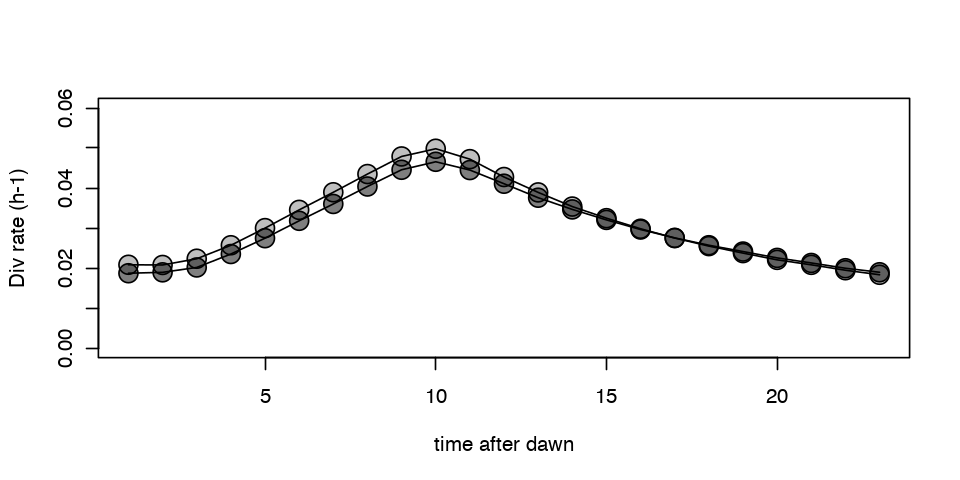

In [8]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

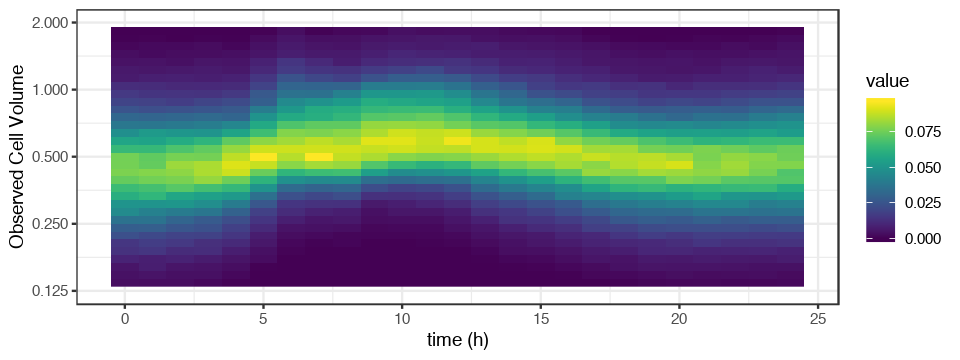

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

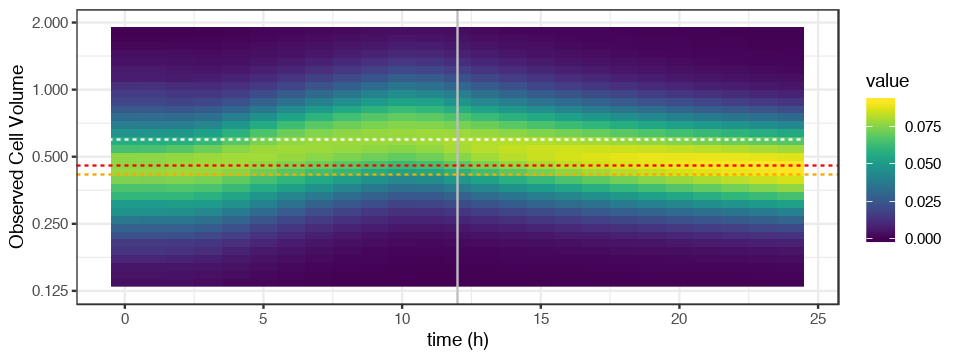

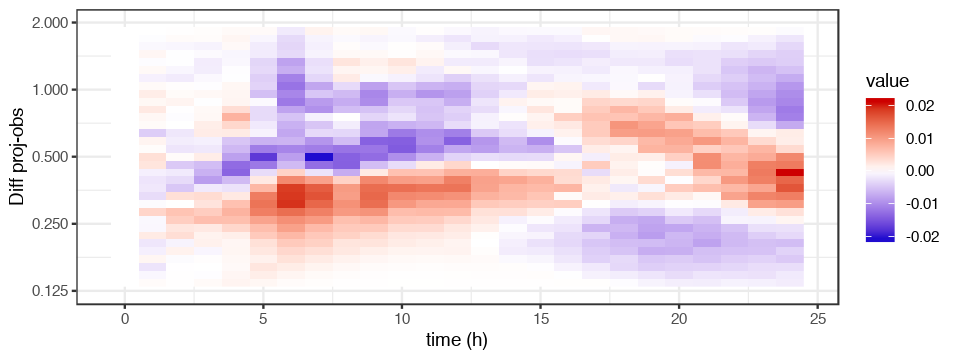

In [9]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

i <- which(Vproj[,12] == max(Vproj[,12]))
f <- which(Vproj[,24] == max(Vproj[,24]))
ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 2. Model with respioration, no cell division
---

To model ```respiration``` in the matrix model of Prochlorococcus, I had to make two major assumptions: 
- Carbon storage represents 30% of carbon fixed by photosynthesis (e.g., Zavreb et al. 2019)
- All carbon storage is consumed at night (ref TBD, but it has to be based on mass flux analysis)

These two assumptions would translate into a 30% reduction of carbon quotas from dusk to dawn (where dark respiration takes place).
A fun excercise. What is the expected reduction in cell diameter caused by respiration?

In [10]:
resp <- 30  # 30% change due to respiration
mass.at.dusk <- 50 # fg, Synecho carbon quotas
mass.at.dawn <- mass.at.dusk * (100-resp)/100
volume.at.dusk <- (0.001*mass.at.dusk/(0.216))^{1/0.860} # Menden-Deuer & Lessard 2000
volume.at.dawn <- (0.001*mass.at.dawn/(0.216))^{1/0.860} 
diam.at.dusk <- 2 * round((3/4*volume.at.dusk /pi)^{1/3},2) 
diam.at.dawn <- 2 * round((3/4*volume.at.dawn /pi)^{1/3},2) 
diff <- diam.at.dusk - diam.at.dawn

print(paste0(resp,'% reduction in a ',mass.at.dusk,' fg Prochlorococcus would translate to = '))
print(paste0(round(100*(volume.at.dusk - volume.at.dawn)/volume.at.dusk),'% reduction in cell volume (',round(volume.at.dusk - volume.at.dawn,3),' cubic microns)'))
print(paste0(round(100*(diam.at.dusk - diam.at.dawn)/diam.at.dusk),'% reduction in cell diameter (',diam.at.dusk - diam.at.dawn,' microns)'))

[1] "30% reduction in a 50 fg Prochlorococcus would translate to = "
[1] "34% reduction in cell volume (0.062 cubic microns)"
[1] "11% reduction in cell diameter (0.08 microns)"


## 2a. Load matrix model, respiration = reduction of 30% cell volume at night

In [11]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 24 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) carbon storage represents 30% of fixed carbon by photosynthesis
            # 2) all carbon storage consumed at night
			# 3) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 7 # set so 30% volume reduction in Vproj
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to fixed carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

### Optimization 
sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [12]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2 <- params[1]
		dmax2 <- params[2]
		b2 <- params[3]
		E_star2 <- params[4]
		resnorm2 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.748315 bestmemit:    0.073486    0.832284    6.249127  302.374386
Iteration: 20 bestvalit: 5.703733 bestmemit:    0.076670    0.659321    2.741499  262.391932
Iteration: 30 bestvalit: 5.701584 bestmemit:    0.076427    0.539380    5.403049  257.164622
Iteration: 40 bestvalit: 5.700703 bestmemit:    0.074553    0.319329   10.691977  262.935102
Iteration: 50 bestvalit: 5.700703 bestmemit:    0.074553    0.204377    1.872676  262.918885
Iteration: 60 bestvalit: 5.700461 bestmemit:    0.076473    0.436258    8.475262  268.650060
Iteration: 70 bestvalit: 5.700461 bestmemit:    0.076473    0.624473    0.947067  268.650060
Iteration: 80 bestvalit: 5.699990 bestmemit:    0.076452    0.985802    1.419316  258.635977
Iteration: 90 bestvalit: 5.699621 bestmemit:    0.076469    0.433764    9.538080  257.979478
Iteration: 100 bestvalit: 5.699595 bestmemit:    0.076449    0.107376    6.675574  257.855199
Iteration: 110 bestvalit: 5.699459 bestmemit:    0.076453    0.756123

## 2b. Load matrix model, respiration = 30% cell growth

In [13]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 24 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) carbon storage represents 30% of fixed carbon by photosynthesis
            # 2) all carbon storage consumed at night
			# 3) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1 # set so 30% volume reduction in Vproj
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to fixed carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

### Optimization 
sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [14]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2. <- params[1]
		dmax2. <- params[2]
		b2. <- params[3]
		E_star2. <- params[4]
		resnorm2. <- opt$optim$bestval

Iteration: 10 bestvalit: 6.326175 bestmemit:    0.110214    0.672775    8.787864  265.318418
Iteration: 20 bestvalit: 6.314864 bestmemit:    0.106991    0.263846    8.290964  258.155034
Iteration: 30 bestvalit: 6.313674 bestmemit:    0.107145    0.187332   11.051030  259.652654
Iteration: 40 bestvalit: 6.312216 bestmemit:    0.107248    0.755869    4.410013  257.421515
Iteration: 50 bestvalit: 6.310778 bestmemit:    0.107222    0.672703   13.344948  259.454313
Iteration: 60 bestvalit: 6.310269 bestmemit:    0.107257    0.230634    5.180127  259.705696
Iteration: 70 bestvalit: 6.310225 bestmemit:    0.107257    0.024898   12.416183  259.780944
Iteration: 80 bestvalit: 6.309821 bestmemit:    0.107267    0.128407    0.528731  259.780944
Iteration: 90 bestvalit: 6.309706 bestmemit:    0.107267    0.298056    0.528731  259.715387
Iteration: 100 bestvalit: 6.309706 bestmemit:    0.107268    0.648996    4.766798  259.698658
Iteration: 110 bestvalit: 6.309706 bestmemit:    0.107269    0.391144

## 2c. Results

In [15]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj2 <- Vproj2. <- V.hists
Nproj2 <- Nproj2. <- N.dist
mu_N2 <- mu_N2. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2, dmax=dmax2,b=b2, E_star=E_star2, resol=resol)
    Nproj2[,hr+1] <- round(B %*% Nproj2[,hr]) # calculate numbers of individuals
	Vproj2[,hr+1] <- B %*% Vproj2[,hr] # calculate the projected size-frequency distribution
	Vproj2[,hr+1] <- Vproj2[,hr+1]/sum(Vproj2[,hr+1]) # normalize distribution so sum = 1
	mu_N2[,hr+1] <- log(sum(Nproj2[,hr+1])/sum(Nproj2[,hr]))/
					((as.numeric(colnames(Nproj2)[hr+1])-as.numeric(colnames(Nproj2)[hr]))/(time.interval))
            		    
  B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2., dmax=dmax2.,b=b2., E_star=E_star2., resol=resol)
  Nproj2.[,hr+1] <- round(B. %*% Nproj2.[,hr]) # calculate numbers of individuals
	Vproj2.[,hr+1] <- B. %*% Vproj2.[,hr] # calculate the projected size-frequency distribution
	Vproj2.[,hr+1] <- Vproj2.[,hr+1]/sum(Vproj2.[,hr+1]) # normalize distribution so sum = 1
	mu_N2.[,hr+1] <- log(sum(Nproj2.[,hr+1])/sum(Nproj2.[,hr]))/
					((as.numeric(colnames(Nproj2.)[hr+1])-as.numeric(colnames(Nproj2.)[hr]))/(time.interval))
						
    }

Nproj2 <- colSums(Nproj2)
colnames(mu_N2) <- colnames(Vproj2)
Nproj2. <- colSums(Nproj2.)
colnames(mu_N2.) <- colnames(Vproj2.)

#############################
## Growth rate calculation ##
#############################
d.mu_N2 <- 24*mean(mu_N2[-c(1:2)], na.rm=T)
d.mu_N2. <- 24*mean(mu_N2.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N2,2),"-",round(d.mu_N2.,2)))

[1] "daily growth rate= 0 - 0"


Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

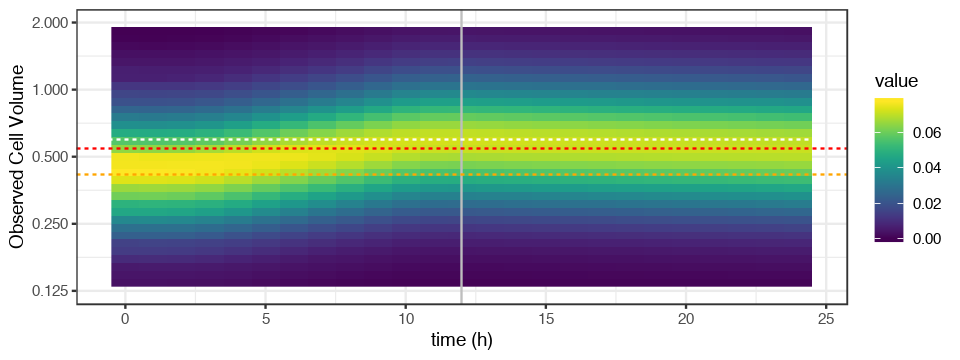

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

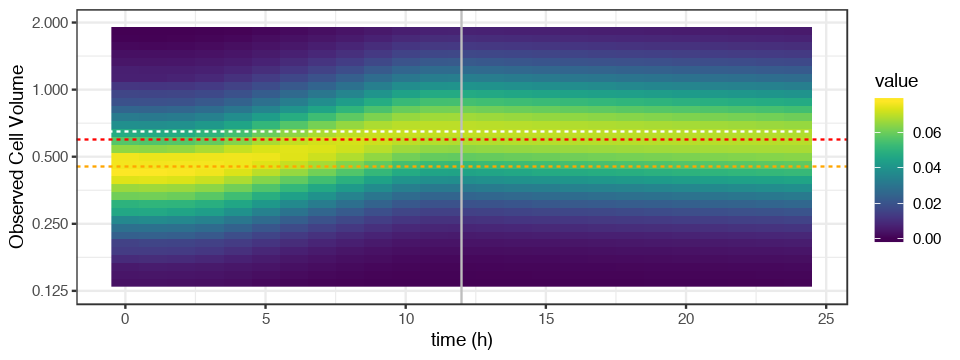

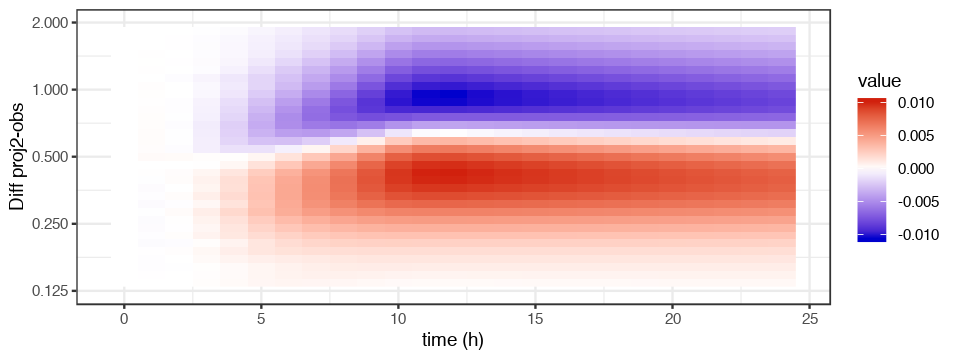

In [16]:
options(repr.plot.width=8, repr.plot.height=3)
i <- which(Vproj2[,12] == max(Vproj2[,12]))
f <- which(Vproj2[,24] == max(Vproj2[,24]))
ggplot(melt(Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

i <- which(Vproj2.[,12] == max(Vproj2.[,12]))
f <- which(Vproj2.[,24] == max(Vproj2.[,24]))
ggplot(melt(Vproj2.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj2-Vproj2.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj2-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)


# 3. Model with Respiration and cell division
---

## 3a. Load matrix model

In [208]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) rate of respiration is a function of photosynthetic rate (gamma function)
			# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 3b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [209]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3 <- params[1]
		dmax3 <- params[2]
		b3 <- params[3]
		E_star3 <- params[4]
		resnorm3 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.732752 bestmemit:    0.168029    0.030192    6.842808  375.738340
Iteration: 20 bestvalit: 4.881251 bestmemit:    0.142931    0.025272    3.789938  199.231489
Iteration: 30 bestvalit: 4.769000 bestmemit:    0.156908    0.030253    4.275553  264.068065
Iteration: 40 bestvalit: 4.765114 bestmemit:    0.157077    0.030909    4.417384  255.200427
Iteration: 50 bestvalit: 4.760553 bestmemit:    0.154292    0.029524    4.360659  257.008421
Iteration: 60 bestvalit: 4.757175 bestmemit:    0.155538    0.030440    4.401269  256.747270
Iteration: 70 bestvalit: 4.757114 bestmemit:    0.155673    0.030583    4.348853  258.794425
Iteration: 80 bestvalit: 4.756948 bestmemit:    0.154809    0.030538    4.342057  258.209183
Iteration: 90 bestvalit: 4.756785 bestmemit:    0.155777    0.030591    4.348360  259.835868
Iteration: 100 bestvalit: 4.755915 bestmemit:    0.153982    0.031120    4.372892  257.320356
Iteration: 110 bestvalit: 4.755915 bestmemit:    0.153982    0.031120

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [210]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3. <- params[1]
		dmax3. <- params[2]
		b3. <- params[3]
		E_star3. <- params[4]
		resnorm3. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.252983 bestmemit:    0.130111    0.013200    6.780511  223.520434
Iteration: 20 bestvalit: 0.227376 bestmemit:    0.146396    0.020162    3.817130  169.737416
Iteration: 30 bestvalit: 0.221540 bestmemit:    0.166380    0.029500    4.578065  256.961354
Iteration: 40 bestvalit: 0.220539 bestmemit:    0.159554    0.027137    4.078947  270.279780
Iteration: 50 bestvalit: 0.220056 bestmemit:    0.158633    0.027615    4.135379  258.315059
Iteration: 60 bestvalit: 0.219897 bestmemit:    0.162828    0.027789    4.106334  258.503390
Iteration: 70 bestvalit: 0.219795 bestmemit:    0.159335    0.027503    4.076877  255.700701
Iteration: 80 bestvalit: 0.219619 bestmemit:    0.158089    0.027353    4.122840  255.394101
Iteration: 90 bestvalit: 0.219619 bestmemit:    0.158089    0.027353    4.122840  255.394101
Iteration: 100 bestvalit: 0.219617 bestmemit:    0.162251    0.028578    4.131488  257.302038
Iteration: 110 bestvalit: 0.219617 bestmemit:    0.162251    0.028578

## 3c. Results

In [211]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj3 <- Vproj3. <- V.hists
Nproj3 <- Nproj3. <- N.dist
mu_N3 <- mu_N3. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3, dmax=dmax3,b=b3, E_star=E_star3, resol=resol)
    Nproj3[,hr+1] <- round(B %*% Nproj3[,hr]) # calculate numbers of individuals
	Vproj3[,hr+1] <- B %*% Vproj3[,hr] # calculate the projected size-frequency distribution
	Vproj3[,hr+1] <- Vproj3[,hr+1]/sum(Vproj3[,hr+1]) # normalize distribution so sum = 1
	mu_N3[,hr+1] <- log(sum(Nproj3[,hr+1])/sum(Nproj3[,hr]))/
					((as.numeric(colnames(Nproj3)[hr+1])-as.numeric(colnames(Nproj3)[hr]))/(time.interval))
            		    
  B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3., dmax=dmax3.,b=b3., E_star=E_star3., resol=resol)
  Nproj3.[,hr+1] <- round(B. %*% Nproj3.[,hr]) # calculate numbers of individuals
	Vproj3.[,hr+1] <- B. %*% Vproj3.[,hr] # calculate the projected size-frequency distribution
	Vproj3.[,hr+1] <- Vproj3.[,hr+1]/sum(Vproj3.[,hr+1]) # normalize distribution so sum = 1
	mu_N3.[,hr+1] <- log(sum(Nproj3.[,hr+1])/sum(Nproj3.[,hr]))/
					((as.numeric(colnames(Nproj3.)[hr+1])-as.numeric(colnames(Nproj3.)[hr]))/(time.interval))
						
    }

Nproj2 <- colSums(Nproj3)
colnames(mu_N3) <- colnames(Vproj3)
Nproj3. <- colSums(Nproj3.)
colnames(mu_N3.) <- colnames(Vproj3.)

#############################
## Growth rate calculation ##
#############################
d.mu_N3 <- 24*mean(mu_N3[-c(1:2)], na.rm=T)
d.mu_N3. <- 24*mean(mu_N3.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N3,2),"-",round(d.mu_N3.,2)))

[1] "daily growth rate= 0.59 - 0.6"


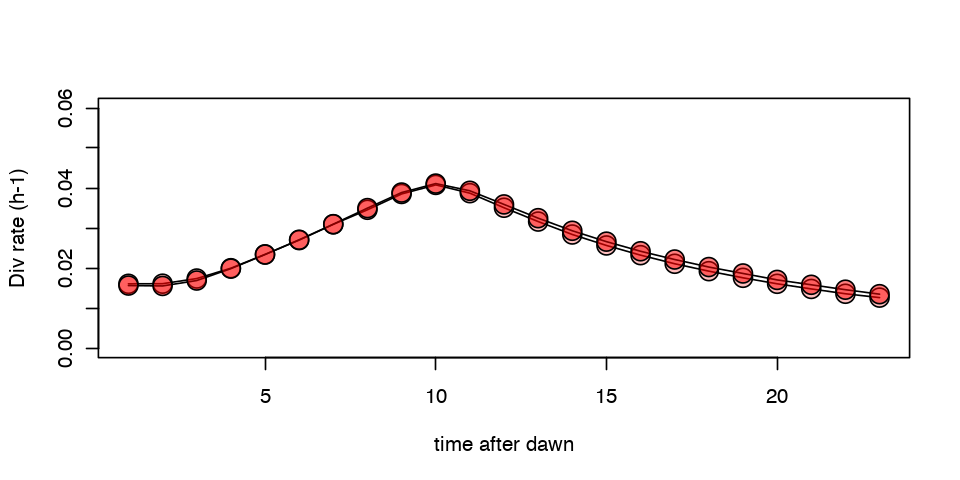

In [212]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N3[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

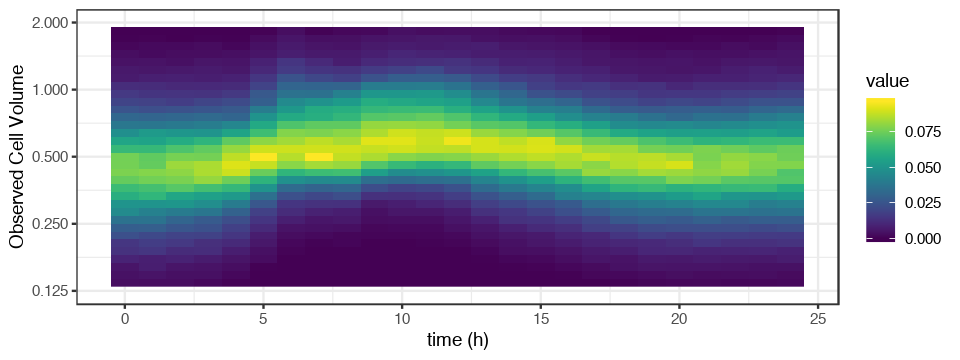

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

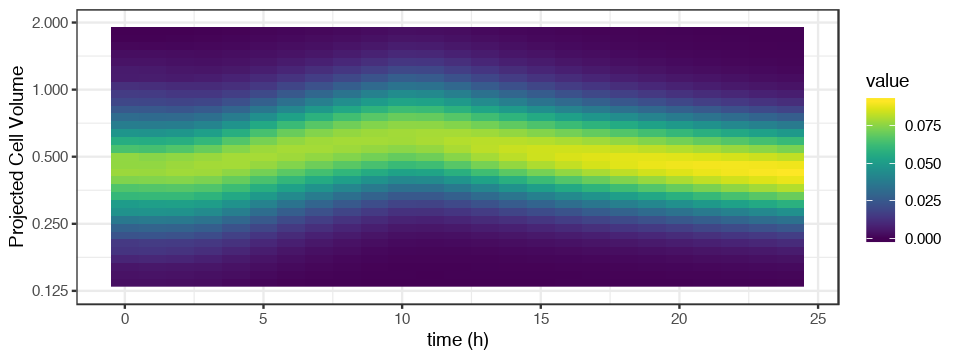

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

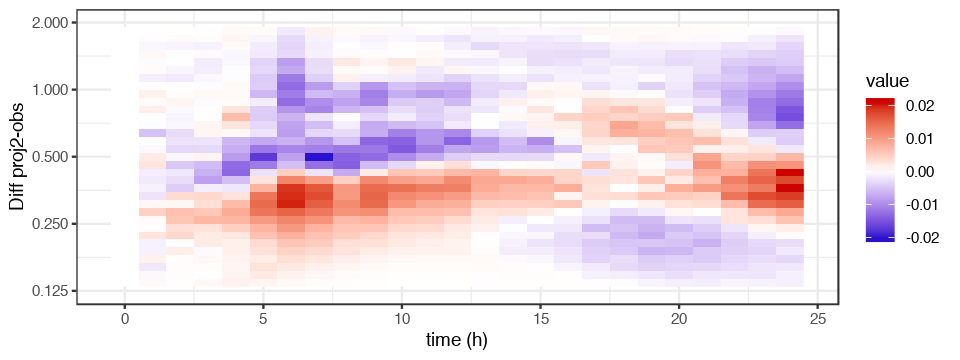

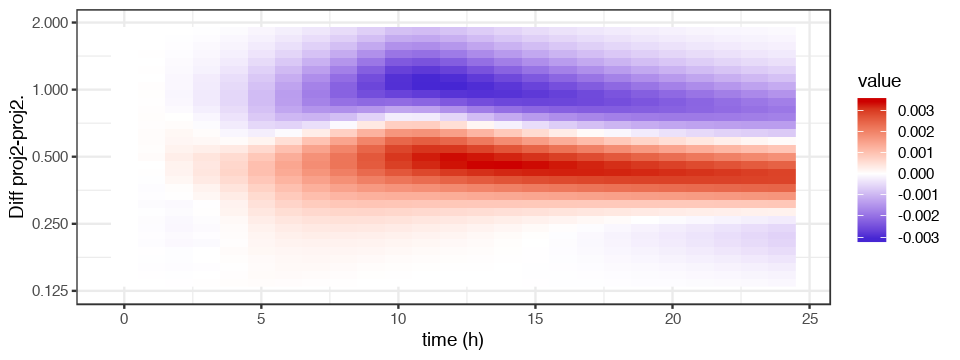

In [213]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj3), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj3-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj2-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj3- Vproj3.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj2-proj2.') +  scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 4. Summary
---

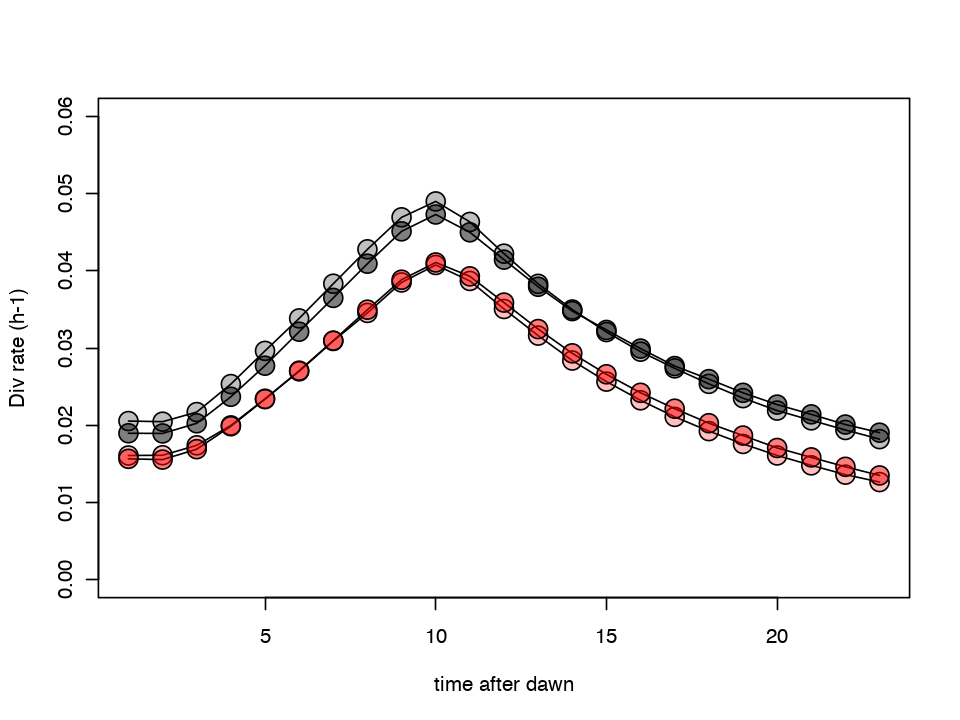

In [214]:
options(repr.plot.width=8, repr.plot.height=6)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
  points(mu_N3[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

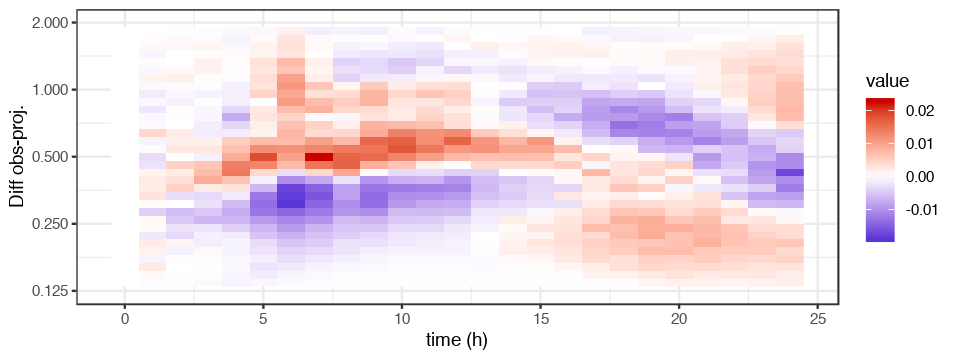

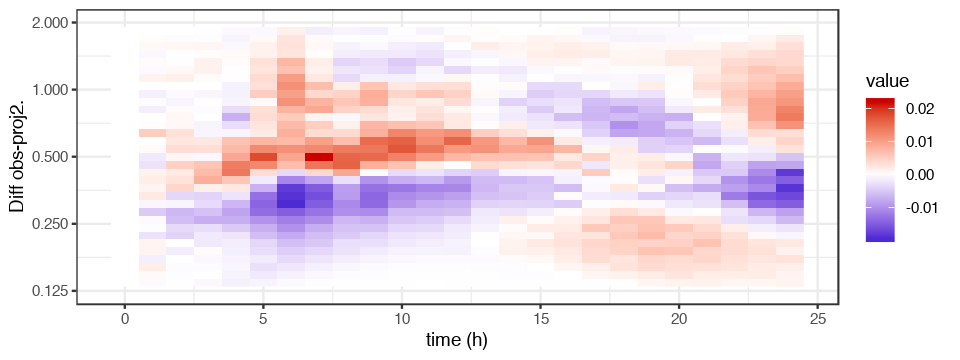

In [215]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists - Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj.') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(V.hists - Vproj3.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj2.') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

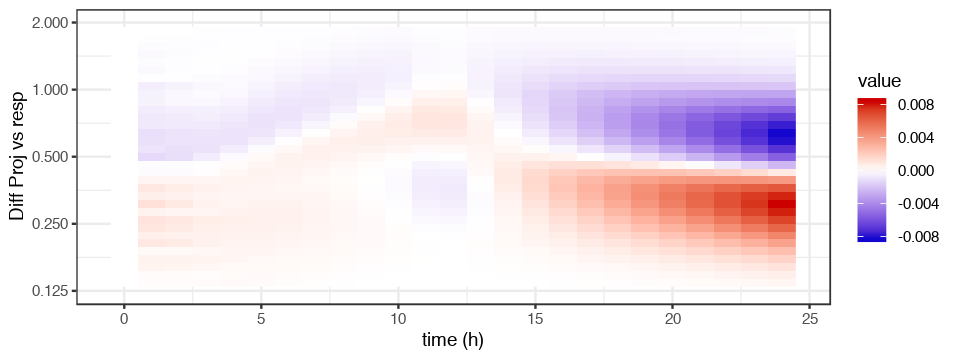

In [216]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(Vproj3. - Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff Proj vs resp') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)